In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
!nvidia-smi

Wed Aug 12 09:10:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 31%   43C    P2    35W / 250W |   6384MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

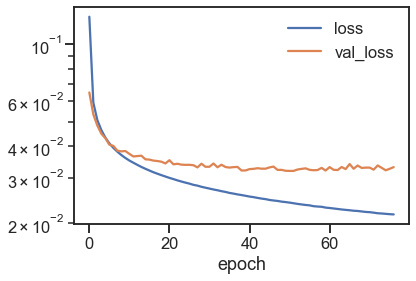

In [3]:
pd.read_csv('20200812_kl_divergence_faster_lr/log.csv').set_index('epoch').plot()
plt.yscale('log')

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [5]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits

model = tf.keras.models.load_model(
    '20200812_kl_divergence_faster_lr/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

In [6]:
cdf = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
test = np.load('split.npz', allow_pickle=True)['test']

In [7]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()
cdf_test['fractional_spin'] = cdf_test.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())
cdf_test_pivot = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot = cdf_test_pivot.reindex(test)
cdf_test_pivot.head()

atom_index,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
smiles,,,,,,,,,,,,,,,,,,,,,
CO/[C]=C1/CCCCC1=O,0.001776,0.103081,0.702058,0.109981,0.001902,0.002830,0.001808,0.005006,0.042844,0.010367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C[CH]C[C@@H]1COOO1,0.047013,0.718680,0.057055,0.019739,0.001834,0.000174,0.000294,0.000185,0.005816,0.043117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC[C@@H](F)C(=[N])N,0.000306,0.000109,0.074523,0.005681,0.122172,0.762786,0.020510,0.000498,0.000044,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[CH2]Nc1ccc(C)c(Cl)c1,0.597656,0.083265,0.045439,0.047257,0.023602,0.053582,0.002519,0.020194,0.000900,0.065124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCc1nc[c]cc1F,0.000266,0.004885,0.036233,0.059242,0.046752,0.721763,0.058991,0.046018,0.003389,0.000182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test_pivot.shape[1]),  # explicit padding required for consistent output shape
                  padding_values=preprocessor.padding_values)

In [9]:
predicted_fractional_spins = tf.nn.softmax(model.predict(test_dataset, verbose=True))

     16/Unknown - 2s 98ms/step

RDKit WARNING: [09:11:24] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [09:11:24]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [09:11:24] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [09:11:24]   BondStereo set to STEREONONE and single bond directions set to NONE.


40/40 [==============================] - 4s 109ms/step


Text(0, 0.5, 'Predicted fractional spin')

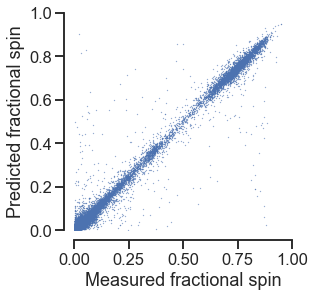

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_test_pivot.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')

Text(0, 0.5, 'Fractional Spin MAE')

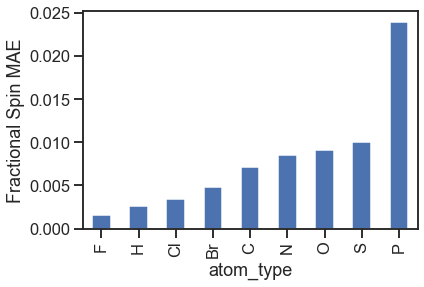

In [43]:
df_pred = pd.DataFrame(predicted_fractional_spins.numpy(), index=test).reset_index().melt(id_vars=['index']).rename(
    columns={'variable': 'atom_index', 'value': 'predicted_fractional_spin', 'index': 'smiles'})

cdf_test_merged = cdf_test.merge(df_pred, on=['smiles', 'atom_index'], how='left')
cdf_test_merged['abs_err'] = (cdf_test_merged['fractional_spin'] - cdf_test_merged['predicted_fractional_spin']).abs()

cdf_test_merged.groupby('atom_type').abs_err.mean().sort_values().plot.bar()
plt.ylabel('Fractional Spin MAE')